In [1]:
# Core libraries
import pandas as pd  # Tabular data manipulation
import numpy as np  # Numerical operations
import warnings  # Control warning messages
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Plotting
import missingno as msno # Visualize missing data

from pathlib import Path
plt.style.use("seaborn-v0_8")

# Scikit-learn utilities
from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
)  # Cross-validation strategies for imbalanced targets
from sklearn.preprocessing import LabelEncoder  # Encode target labels
from sklearn.metrics import log_loss  # Evaluation metric
from sklearn.ensemble import VotingClassifier  # Ensemble meta-estimator

# Gradient boosting libraries
from xgboost import XGBClassifier  # XGBoost classifier
from lightgbm import LGBMClassifier  # LightGBM classifier
from catboost import CatBoostClassifier  # CatBoost classifier

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Visualization & Auto-Save Utilities

from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

AUTO_SAVE = True  # toggle to disable if needed
FIG_DIR = Path("Reports")
FIG_DIR.mkdir(exist_ok=True)

_fig_seq = 0

def _sanitize(name: str) -> str:
    return (
        name.lower()
        .replace(" ", "_")
        .replace("/", "-")
        .replace("__", "_")
        or "figure"
    )

def _save_current_fig(title_hint: str = "figure"):
    global _fig_seq
    _fig_seq += 1
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    fname = f"{_fig_seq:02d}_{_sanitize(title_hint)}_{timestamp}.png"
    plt.gcf().savefig(FIG_DIR / fname, dpi=150, bbox_inches="tight")
    print(f"[AutoSave] Saved figure: Reports/{fname}")

_original_show = plt.show

def _autosave_show(*args, **kwargs):
    if AUTO_SAVE:
        fig = plt.gcf()
        # Try to infer a title from the first axes
        title_candidates = []
        if fig.axes:
            for ax in fig.axes:
                t = ax.get_title()
                if t:
                    title_candidates.append(t)
        title_hint = title_candidates[0] if title_candidates else "figure"
        _save_current_fig(title_hint)
    return _original_show(*args, **kwargs)

plt.show = _autosave_show  # Monkey patch to auto-save on every show()
print(f"[Setup] Auto-save is {'ON' if AUTO_SAVE else 'OFF'}; figures will be stored in 'Reports/'.")

[Setup] Auto-save is ON; figures will be stored in 'Reports/'.


In [3]:
# --- CONFIGURATION ---
N_SPLITS = 10  # Cross-validation folds
RANDOM_STATE = 42  # Seed for reproducibility
TARGET_COL = "Status"  # Target label in train data

DATA_DIR = "data/"  # Relative path from notebooks/ to data/

# Load data
try:
    # Read CSVs from the data directory
    train_df = pd.read_csv(DATA_DIR + "train.csv")
    test_df = pd.read_csv(DATA_DIR + "test.csv")
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"Error: train.csv or test.csv not found in {DATA_DIR}")

# Basic sanity checks
if TARGET_COL not in train_df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in train.csv")

# Combine for consistent preprocessing across train/test
# Keep ids to restore after encoding/feature engineering
test_ids = test_df["id"]
train_df["is_test"] = 0
test_df["is_test"] = 1

y = train_df[TARGET_COL]  # Target values

# Create a combined frame without the target
data = pd.concat([train_df.drop(columns=[TARGET_COL]), test_df], ignore_index=True)
print(f"Combined data shape (train + test): {data.shape}")
print(f"Columns (first 10): {list(data.columns)[:10]} ...")

Data loaded successfully.
Train shape: (15000, 20) | Test shape: (10000, 19)
Combined data shape (train + test): (25000, 20)
Columns (first 10): ['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin'] ...


In [4]:
df = train_df.copy()
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_test
0,0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,...,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,D,0
1,1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,...,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,D,0
2,2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,...,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,D,0
3,3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,...,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,D,0
4,4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,...,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,D,0


In [5]:
df.isna().sum()

id                  0
N_Days              0
Drug             6543
Age                 0
Sex                 0
Ascites          6536
Hepatomegaly     6547
Spiders          6551
Edema               0
Bilirubin           0
Cholesterol      8377
Albumin             0
Copper           6662
Alk_Phos         6550
SGOT             6554
Tryglicerides    8426
Platelets         538
Prothrombin        19
Stage               0
Status              0
is_test             0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8457 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8464 non-null   object 
 6   Hepatomegaly   8453 non-null   object 
 7   Spiders        8449 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6623 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8338 non-null   float64
 13  Alk_Phos       8450 non-null   float64
 14  SGOT           8446 non-null   float64
 15  Tryglicerides  6574 non-null   float64
 16  Platelets      14462 non-null  float64
 17  Prothrombin    14981 non-null  float64
 18  Stage 

In [8]:
df.nunique()

id               15000
N_Days             571
Drug                 2
Age                390
Sex                  2
Ascites              2
Hepatomegaly         2
Spiders              3
Edema                3
Bilirubin          118
Cholesterol        218
Albumin            166
Copper             170
Alk_Phos           376
SGOT               208
Tryglicerides      158
Platelets          263
Prothrombin         49
Stage                4
Status               3
is_test              1
dtype: int64

In [9]:
# Exploring Data

print("Categories in 'Drug' variable:     ", end=" ")
print(df["Drug"].unique())

print("Categories in 'Sex' variable:  ", end=" ")
print(df["Sex"].unique())

print("Categories in 'Ascites' variable:", end=" ")
print(df["Ascites"].unique())

print("Categories in 'Hepatomegaly' variable:     ", end=" ")
print(df["Hepatomegaly"].unique())

print("Categories in 'Spiders' variable:     ", end=" ")
print(df["Spiders"].unique())

print("Categories in 'Edema' variable:     ", end=" ")
print(df["Edema"].unique())

print("Categories in 'Stage' variable:     ", end=" ")
print(df["Stage"].unique())

print("Categories in 'Status' variable:     ", end=" ")
print(df["Status"].unique())

Categories in 'Drug' variable:      ['Placebo' 'D-penicillamine' nan]
Categories in 'Sex' variable:   ['F' 'M']
Categories in 'Ascites' variable: ['N' nan 'Y']
Categories in 'Hepatomegaly' variable:      ['Y' nan 'N']
Categories in 'Spiders' variable:      ['N' 'Y' nan '119.35']
Categories in 'Edema' variable:      ['N' 'S' 'Y']
Categories in 'Stage' variable:      [4. 2. 3. 1.]
Categories in 'Status' variable:      ['D' 'C' 'CL']


In [10]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != "O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

# print columns
print(
    "We have {} numerical features : {}".format(len(numeric_features), numeric_features)
)
print(
    "\nWe have {} categorical features : {}".format(
        len(categorical_features), categorical_features
    )
)

We have 14 numerical features : ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'is_test']

We have 7 categorical features : ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']


In [11]:
# Analyze the target variable: Status distribution
status_c = df[df["Status"] == "C"].shape[0]
status_cl = df[df["Status"] == "CL"].shape[0]
status_d = df[df["Status"] == "D"].shape[0]

print(f"Number of patients with Status C (Censored): {status_c}")
print(f"Number of patients with Status CL (Censored due to liver tx): {status_cl}")
print(f"Number of patients with Status D (Death): {status_d}")
print(f"\nTotal patients: {len(df)}")

Number of patients with Status C (Censored): 10234
Number of patients with Status CL (Censored due to liver tx): 343
Number of patients with Status D (Death): 4423

Total patients: 15000


In [12]:
# Analyze patients by disease Stage
stage_1 = df[df["Stage"] == 1.0].shape[0]
stage_2 = df[df["Stage"] == 2.0].shape[0]
stage_3 = df[df["Stage"] == 3.0].shape[0]
stage_4 = df[df["Stage"] == 4.0].shape[0]

print(f"Number of patients in Stage 1: {stage_1}")
print(f"Number of patients in Stage 2: {stage_2}")
print(f"Number of patients in Stage 3: {stage_3}")
print(f"Number of patients in Stage 4: {stage_4}")

Number of patients in Stage 1: 795
Number of patients in Stage 2: 3326
Number of patients in Stage 3: 5796
Number of patients in Stage 4: 5083


[AutoSave] Saved figure: Reports/01_distribution_of_bilirubin_levels_20251127-205612.png


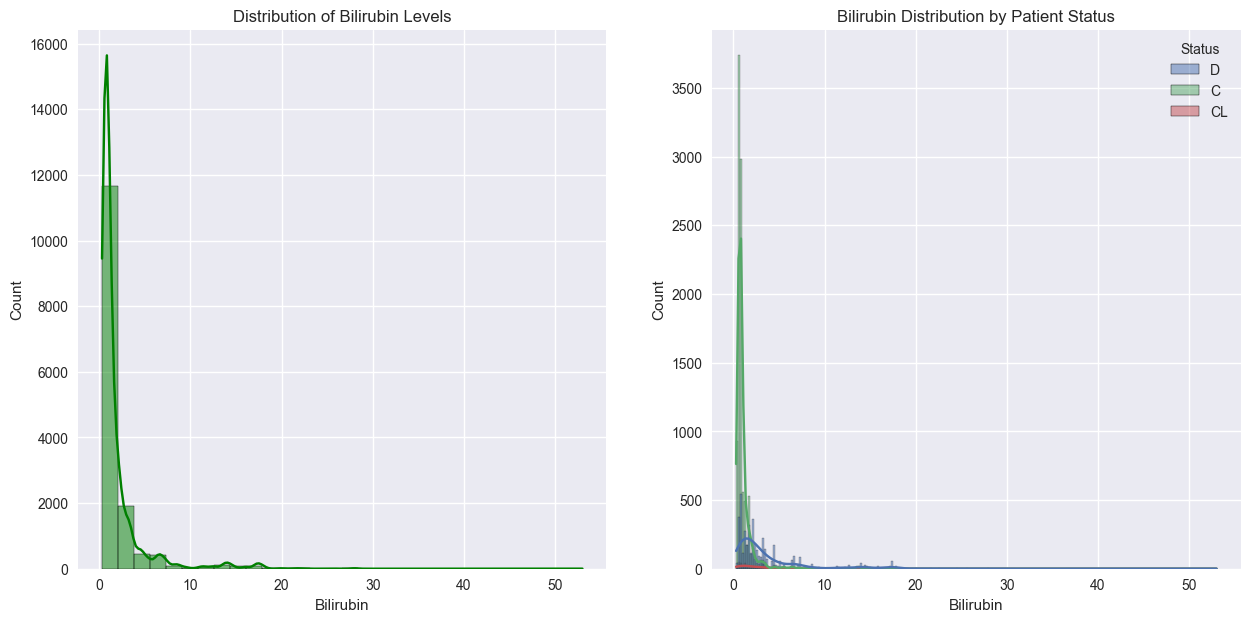

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x="Bilirubin", bins=30, kde=True, color="g")
plt.title("Distribution of Bilirubin Levels")
plt.subplot(122)
sns.histplot(data=df, x="Bilirubin", kde=True, hue="Status")
plt.title("Bilirubin Distribution by Patient Status")
plt.show()

[AutoSave] Saved figure: Reports/02_distribution_of_albumin_levels_20251127-205615.png


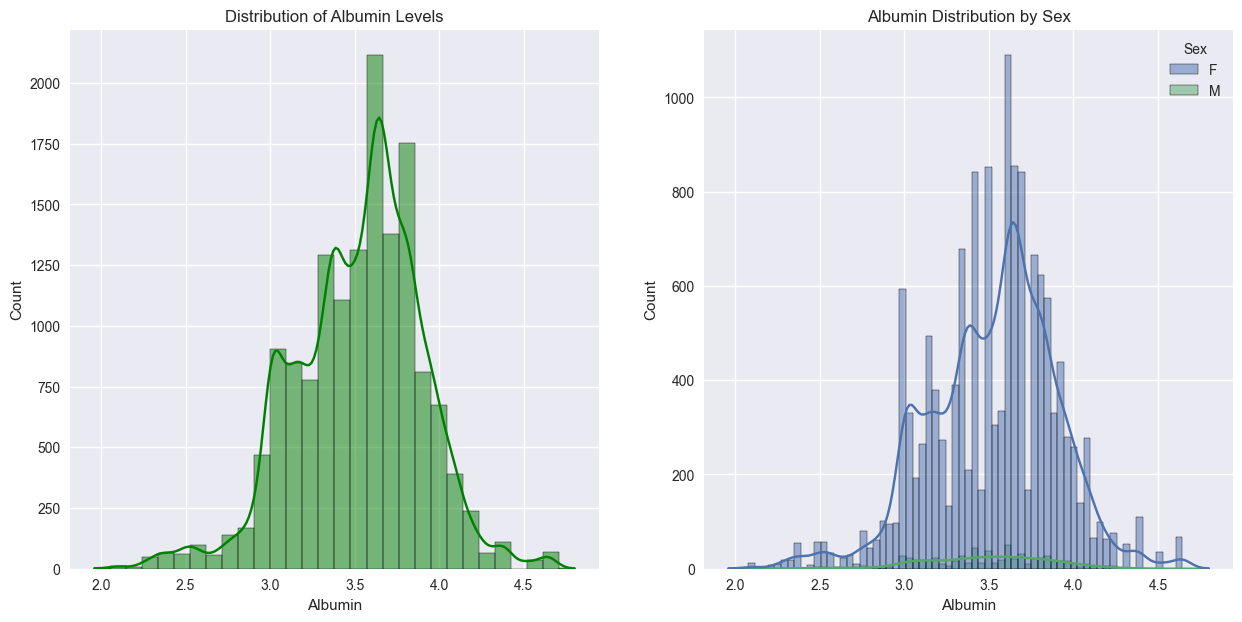

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x="Albumin", bins=30, kde=True, color="g")
plt.title("Distribution of Albumin Levels")
plt.subplot(122)
sns.histplot(data=df, x="Albumin", kde=True, hue="Sex")
plt.title("Albumin Distribution by Sex")
plt.show()

Quick EDA: plotting target distribution, histograms, correlation heatmap, and missingness...
[AutoSave] Saved figure: Reports/03_target_class_distribution_(train)_20251127-205616.png


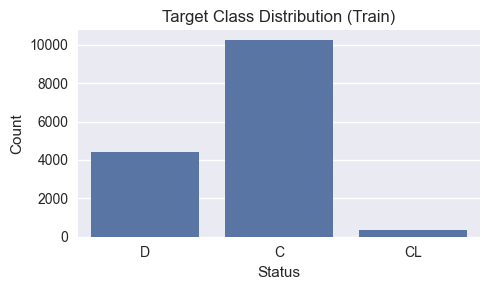

[AutoSave] Saved figure: Reports/04_age_20251127-205617.png


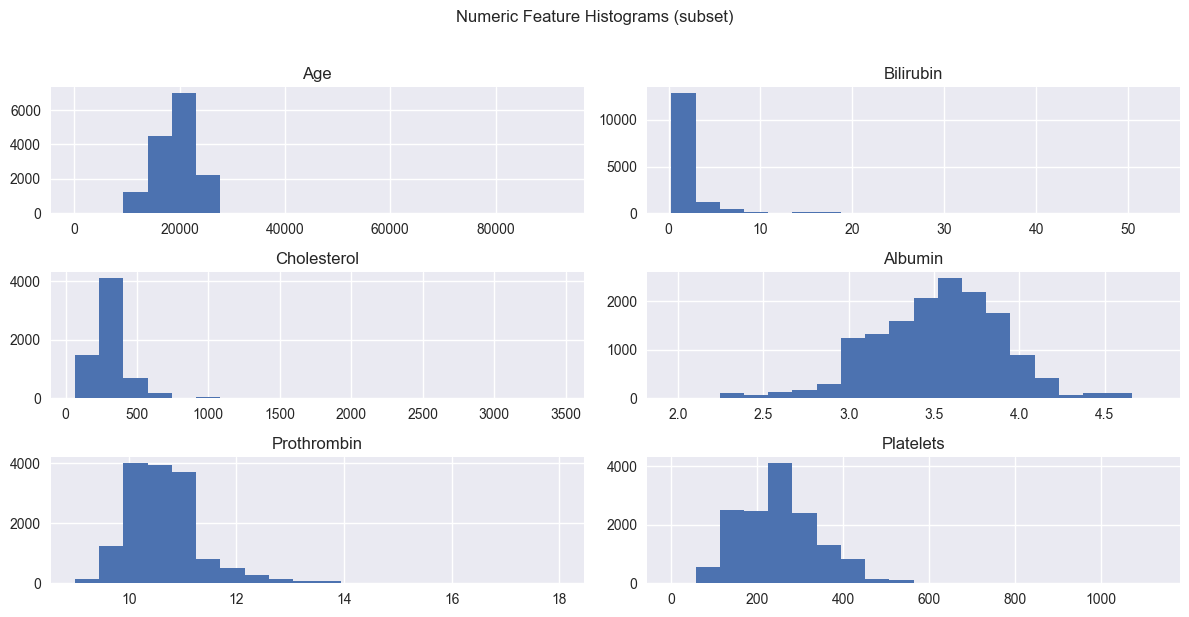

[AutoSave] Saved figure: Reports/05_correlation_heatmap_(train_numeric_features)_20251127-205618.png


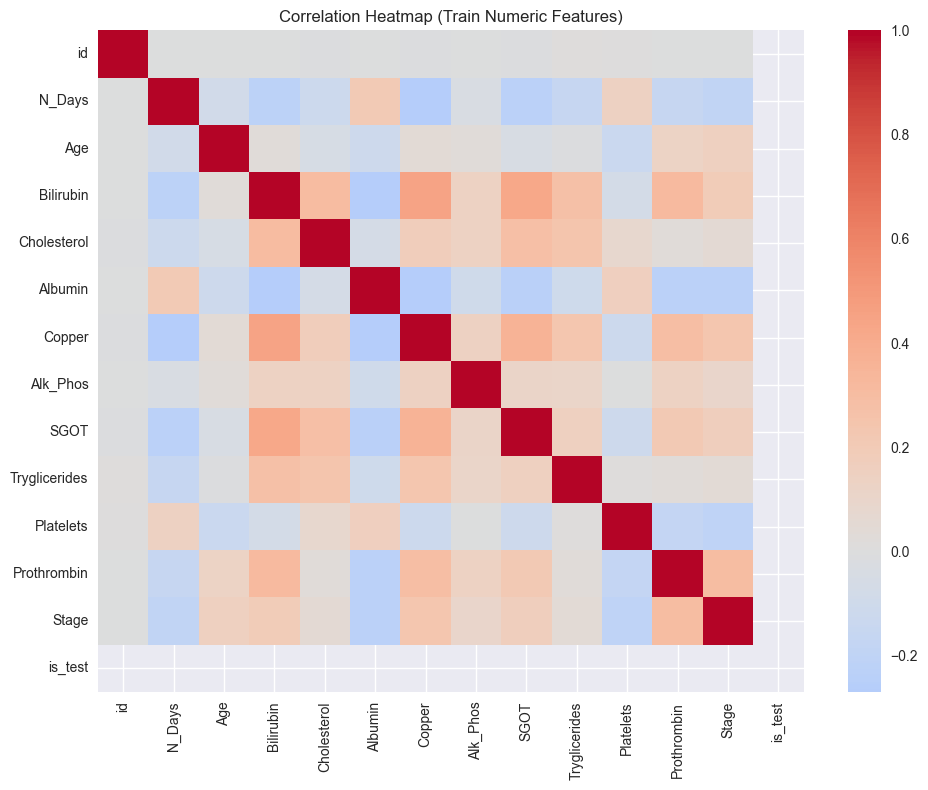

[AutoSave] Saved figure: Reports/06_missing_values_(top_20)_-_train_20251127-205618.png


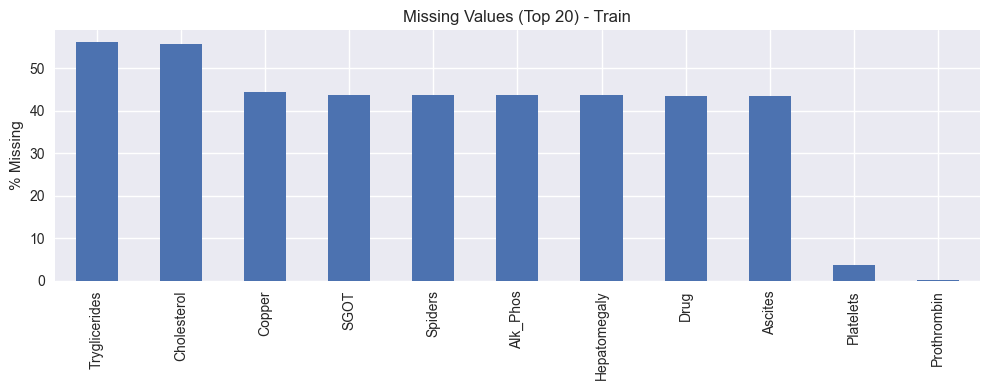

In [15]:
# --- QUICK EDA: Target, Distributions, Correlation, Missingness ---
import matplotlib.pyplot as plt
import seaborn as sns

print(
    "Quick EDA: plotting target distribution, histograms, correlation heatmap, and missingness..."
)

# 1) Target class distribution (train only)
plt.figure(figsize=(5, 3))
sns.countplot(x=train_df[TARGET_COL])
plt.title("Target Class Distribution (Train)")
plt.xlabel(TARGET_COL)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Numeric feature histograms (subset if many columns)
num_cols_train = train_df.select_dtypes(include=[np.number]).columns.tolist()
sample_num_cols = [
    c
    for c in ["Age", "Bilirubin", "Cholesterol", "Albumin", "Prothrombin", "Platelets"]
    if c in num_cols_train
]

if sample_num_cols:
    train_df[sample_num_cols].hist(figsize=(12, 6), bins=20)
    plt.suptitle("Numeric Feature Histograms (subset)", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print(
        "No standard numeric columns found for histograms subset; plotting first few numeric columns."
    )
    fallback_cols = num_cols_train[:6]
    if fallback_cols:
        train_df[fallback_cols].hist(figsize=(12, 6), bins=20)
        plt.suptitle("Numeric Feature Histograms (fallback)", y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric columns available for histograms.")

# 3) Correlation matrix heatmap (train numeric)
if len(num_cols_train) >= 2:
    corr = train_df[num_cols_train].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
    plt.title("Correlation Heatmap (Train Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation matrix.")

# 4) Missing values percentage bar plot (top 20)
missing_pct = train_df.isna().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
if not missing_pct.empty:
    plt.figure(figsize=(10, 4))
    (missing_pct.head(20) * 100).plot(kind="bar")
    plt.ylabel("% Missing")
    plt.title("Missing Values (Top 20) - Train")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in train data.")

[EDA] Plotting categorical distributions, pairplot (subset), and PCA 2D scatter...
[AutoSave] Saved figure: Reports/07_categorical_distribution:_drug_20251127-205619.png


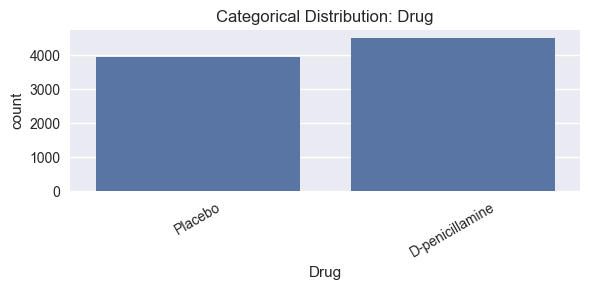

[AutoSave] Saved figure: Reports/08_categorical_distribution:_ascites_20251127-205619.png


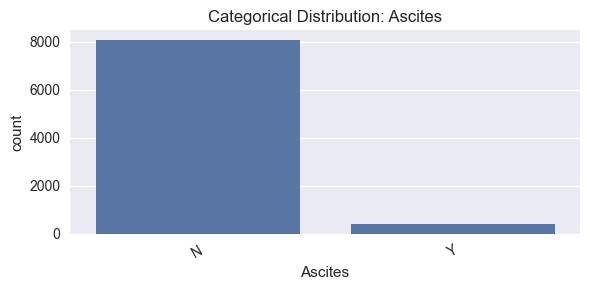

[AutoSave] Saved figure: Reports/09_categorical_distribution:_hepatomegaly_20251127-205619.png


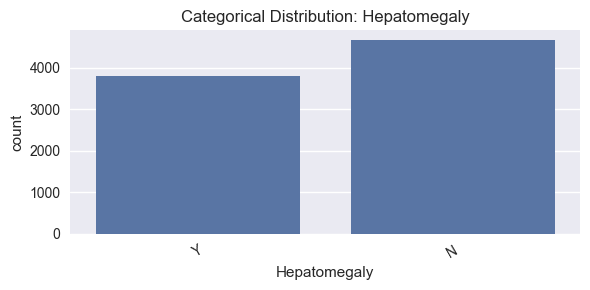

[AutoSave] Saved figure: Reports/10_categorical_distribution:_spiders_20251127-205620.png


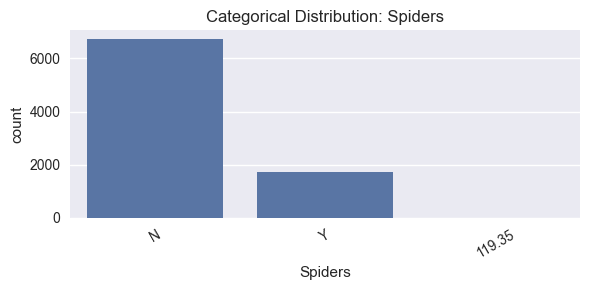

[AutoSave] Saved figure: Reports/11_categorical_distribution:_edema_20251127-205620.png


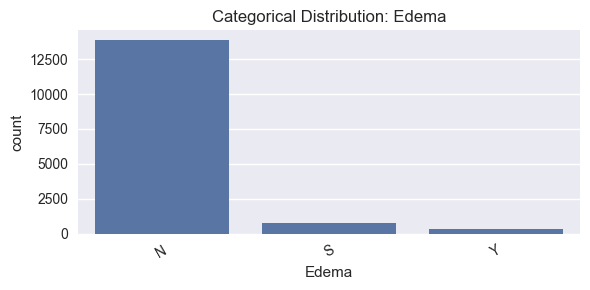

[AutoSave] Saved figure: Reports/12_figure_20251127-205627.png


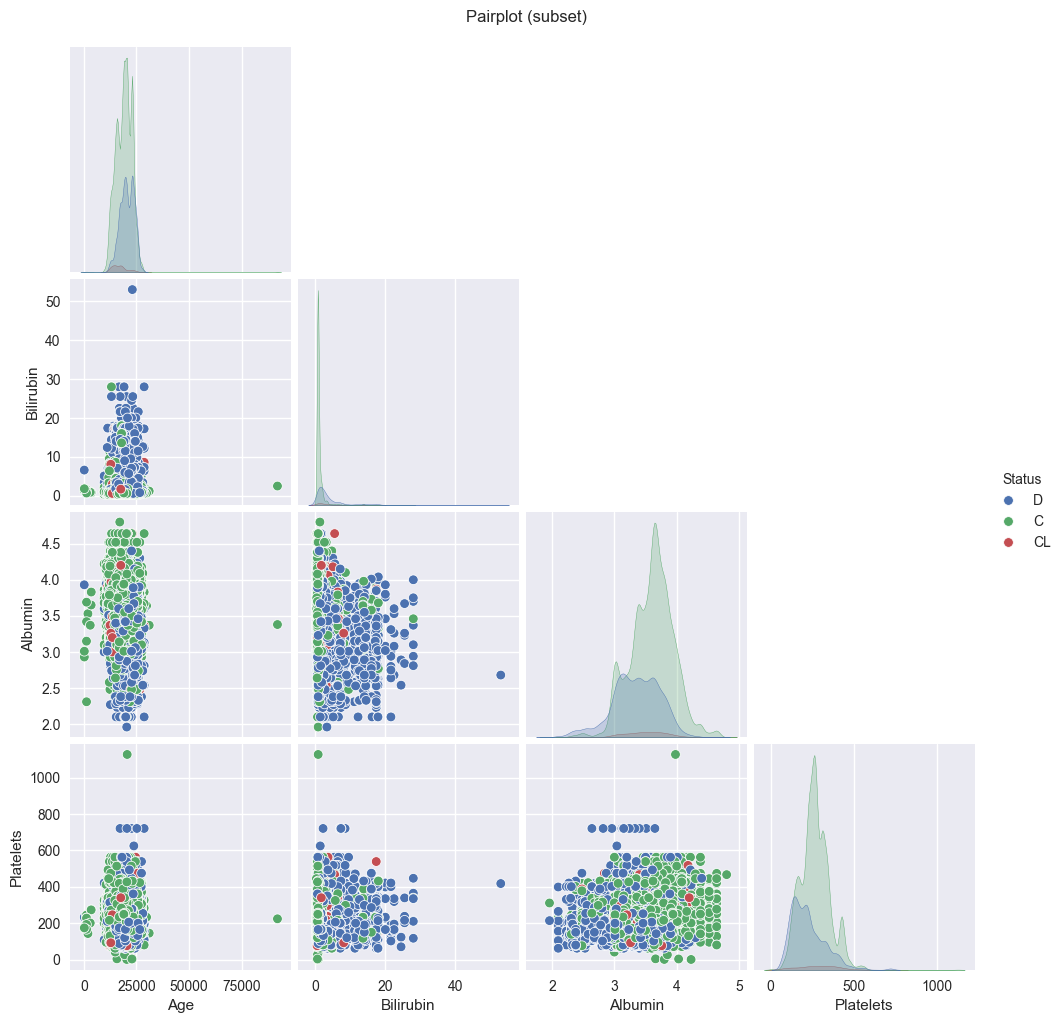

[AutoSave] Saved figure: Reports/13_pca_2d_scatter_(train_numeric)_20251127-205633.png


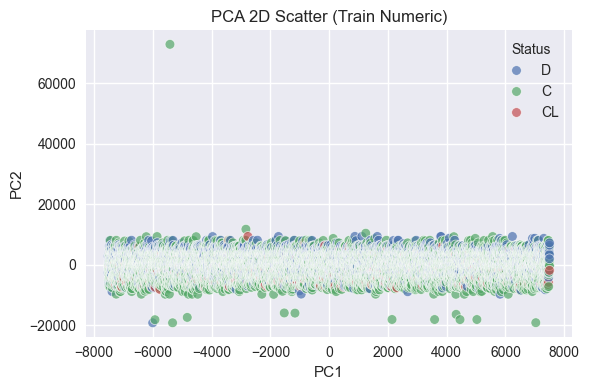

In [16]:
# --- EDA: Categorical Distributions & Pairplot/PCA ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

print(
    "[EDA] Plotting categorical distributions, pairplot (subset), and PCA 2D scatter..."
)

# 1) Categorical distributions (top categories)
cat_cols_train = train_df.select_dtypes(include=["object"]).columns.tolist()
show_cats = [
    c
    for c in ["Drug", "Ascites", "Hepatomegaly", "Spiders", "Edema"]
    if c in cat_cols_train
]
for c in show_cats:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=train_df[c])
    plt.title(f"Categorical Distribution: {c}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# 2) Pairplot on a small numeric subset to visualize separability
num_cols_train = train_df.select_dtypes(include=[np.number]).columns.tolist()
pair_cols = [
    c for c in ["Age", "Bilirubin", "Albumin", "Platelets"] if c in num_cols_train
]
if len(pair_cols) >= 2:
    sns.pairplot(train_df[pair_cols + [TARGET_COL]], hue=TARGET_COL, corner=True)
    plt.suptitle("Pairplot (subset)", y=1.02)
    plt.show()
else:
    print("[EDA] Not enough numeric columns for pairplot subset.")

# 3) PCA 2D scatter (numeric only)
if len(num_cols_train) >= 2:
    X_num = train_df[num_cols_train].fillna(train_df[num_cols_train].median())
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    comps = pca.fit_transform(X_num)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=comps[:, 0], y=comps[:, 1], hue=train_df[TARGET_COL], alpha=0.7)
    plt.title("PCA 2D Scatter (Train Numeric)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()
else:
    print("[EDA] Not enough numeric columns for PCA.")

In [17]:
# --- PREPROCESSING & FEATURE ENGINEERING ---

print("[Preprocessing] Starting feature engineering and encoding...")

missing_before = int(data.isna().sum().sum())

# 1. Impute Missing Values
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()

for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)
for col in cat_cols:
    data[col].fillna("Missing", inplace=True)

missing_after = int(data.isna().sum().sum())
print(
    f"[Preprocessing] Imputed missing values: before={missing_before:,} | after={missing_after:,}"
)
print(
    f"[Preprocessing] Numeric cols={len(num_cols)} | Categorical cols={len(cat_cols)}"
)

# 2. Advanced Feature Engineering
# Log transform skewed features to normalize distribution
skewed_cols = [
    "Bilirubin",
    "Cholesterol",
    "Alk_Phos",
    "SGOT",
    "Tryglicerides",
    "Prothrombin",
    "Copper",
]
created_log_feats = []
for col in skewed_cols:
    if col in data.columns:
        new_col = f"Log_{col}"
        data[new_col] = np.log1p(data[col])
        created_log_feats.append(new_col)
print(
    f"[Preprocessing] Created log features: {len(created_log_feats)} -> {created_log_feats if created_log_feats else 'None'}"
)

# Domain specific ratios
data["Bili_Alb_Ratio"] = data["Bilirubin"] / (data["Albumin"] + 1e-6)
data["Prothr_Plat_Ratio"] = data["Prothrombin"] / (data["Platelets"] + 1e-6)
data["Diagnosis_Date"] = data["Age"] - data["N_Days"]
print(
    "[Preprocessing] Added ratio/date features: Bili_Alb_Ratio, Prothr_Plat_Ratio, Diagnosis_Date"
)

# 3. Encoding
# Label Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_map = {i: cls for i, cls in enumerate(le.classes_)}
print(f"[Encoding] Target classes ({len(le.classes_)}): {class_map}")

# One-Hot Encode Categorical Features
shape_before = data.shape
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
shape_after = data.shape
print(
    f"[Encoding] One-hot encoded {len(cat_cols)} columns: shape {shape_before} -> {shape_after}"
)

# Drop ID and utility columns
if "id" in data.columns:
    data = data.drop(columns=["id"])
    print("[Cleanup] Dropped 'id' column.")
else:
    print("[Cleanup] 'id' column not present after encoding.")

# --- DATA SPLIT ---
X_train = data[data["is_test"] == 0].drop(columns=["is_test"]).values
X_test = data[data["is_test"] == 1].drop(columns=["is_test"]).values
print(
    f"[Split] X_train={X_train.shape} | X_test={X_test.shape} | Features={X_train.shape[1]}"
)

[Preprocessing] Starting feature engineering and encoding...
[Preprocessing] Imputed missing values: before=105,710 | after=0
[Preprocessing] Numeric cols=14 | Categorical cols=6
[Preprocessing] Created log features: 7 -> ['Log_Bilirubin', 'Log_Cholesterol', 'Log_Alk_Phos', 'Log_SGOT', 'Log_Tryglicerides', 'Log_Prothrombin', 'Log_Copper']
[Preprocessing] Added ratio/date features: Bili_Alb_Ratio, Prothr_Plat_Ratio, Diagnosis_Date
[Encoding] Target classes (3): {0: 'C', 1: 'CL', 2: 'D'}
[Encoding] One-hot encoded 6 columns: shape (25000, 30) -> (25000, 36)
[Cleanup] Dropped 'id' column.
[Split] X_train=(15000, 34) | X_test=(10000, 34) | Features=34


In [18]:
# --- MODEL DEFINITIONS ---

print("[Models] Initializing model configurations...")

# 1. XGBoost
xgb_params = {
    "n_estimators": 4300,
    "learning_rate": 0.002,
    "max_depth": 5,
    # "num_leaves": 63,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    "tree_method": "hist",
}

# 2. LightGBM
lgbm_params = {
    "n_estimators": 4900,
    "learning_rate": 0.01,
    "max_depth": 8,
    "num_leaves": 63,
    "subsample": 0.9,
    "colsample_bytree": 0.000009,
    "objective": "multiclass",
    "metric": "multi_logloss",
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
    "verbose": -1,
    # "tree_method": "hist",
}

# 3. CatBoost
cat_params = {
    "iterations": 3500,
    "learning_rate": 0.01,
    "depth": 5,
    "loss_function": "MultiClass",
    "verbose": 0,
    "random_seed": RANDOM_STATE,
    "allow_writing_files": False,
}

# Instantiate models
xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)
cat_model = CatBoostClassifier(**cat_params)

# Brief summaries
print(f"[Models] XGB param keys: {sorted(list(xgb_params.keys()))}")
print(f"[Models] LGBM param keys: {sorted(list(lgbm_params.keys()))}")
print(f"[Models] CatBoost param keys: {sorted(list(cat_params.keys()))}")
print("[Models] Model objects created: xgb_model, lgbm_model, cat_model")

[Models] Initializing model configurations...
[Models] XGB param keys: ['colsample_bytree', 'eval_metric', 'learning_rate', 'max_depth', 'n_estimators', 'n_jobs', 'objective', 'random_state', 'subsample', 'tree_method']
[Models] LGBM param keys: ['colsample_bytree', 'learning_rate', 'max_depth', 'metric', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'subsample', 'verbose']
[Models] CatBoost param keys: ['allow_writing_files', 'depth', 'iterations', 'learning_rate', 'loss_function', 'random_seed', 'verbose']
[Models] Model objects created: xgb_model, lgbm_model, cat_model


In [19]:
# --- ENSEMBLE TRAINING ---

from time import time

print("[Training] Starting soft-voting ensemble training...")

# Soft Voting Ensemble
ensemble = VotingClassifier(
    estimators=[("xgb", xgb_model), ("lgbm", lgbm_model), ("cat", cat_model)],
    voting="soft",
    weights=[1.9, 4.6, 2.6],  # Adjust if one model consistently dominates
)

kf = RepeatedStratifiedKFold(
    n_splits=8,  # folds per repeat
    n_repeats=1,  # repeats (total_folds = n_splits * n_repeats)
    random_state=RANDOM_STATE,
)

# Preallocate OOF/test predictions
n_classes = len(np.unique(y_encoded))
oof_preds = np.zeros((X_train.shape[0], n_classes))
test_preds = np.zeros((X_test.shape[0], n_classes))

# Derive total folds for averaging and progress
total_folds = kf.get_n_splits(X_train, y_encoded)
print(
    f"[Training] Folds={total_folds} | Features={X_train.shape[1]} | Classes={n_classes}"
)

fold_losses = []
start_time = time()

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_encoded), start=1):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_encoded[train_idx], y_encoded[val_idx]

    print(f"[Training][Fold {fold}/{total_folds}] Fitting ensemble...")
    ensemble.fit(X_tr, y_tr)

    # OOF predictions
    val_pred = ensemble.predict_proba(X_val)
    oof_preds[val_idx] = val_pred

    # Accumulate test predictions (average after loop)
    test_preds += ensemble.predict_proba(X_test)

    fold_loss = log_loss(y_val, val_pred)
    fold_losses.append(fold_loss)
    print(f"[Training][Fold {fold}/{total_folds}] LogLoss: {fold_loss:.5f}")

# Average test predictions across folds
test_preds /= total_folds

# --- EVALUATION ---
final_logloss = log_loss(y_encoded, oof_preds)
elapsed = time() - start_time

print("\n[Training] Completed.")
print(f"[Training] OOF LogLoss: {final_logloss:.5f}")
print(
    f"[Training] Folds mean={np.mean(fold_losses):.5f} | std={np.std(fold_losses):.5f} | "
    f"min={np.min(fold_losses):.5f} | max={np.max(fold_losses):.5f}"
)
print(f"[Training] Time elapsed: {elapsed:.1f}s")

[Training] Starting soft-voting ensemble training...
[Training] Folds=8 | Features=34 | Classes=3
[Training][Fold 1/8] Fitting ensemble...
[Training][Fold 1/8] LogLoss: 0.33878
[Training][Fold 2/8] Fitting ensemble...
[Training][Fold 2/8] LogLoss: 0.33475
[Training][Fold 3/8] Fitting ensemble...
[Training][Fold 3/8] LogLoss: 0.37765
[Training][Fold 4/8] Fitting ensemble...
[Training][Fold 4/8] LogLoss: 0.36258
[Training][Fold 5/8] Fitting ensemble...
[Training][Fold 5/8] LogLoss: 0.34028
[Training][Fold 6/8] Fitting ensemble...
[Training][Fold 6/8] LogLoss: 0.33225
[Training][Fold 7/8] Fitting ensemble...
[Training][Fold 7/8] LogLoss: 0.35757
[Training][Fold 8/8] Fitting ensemble...
[Training][Fold 8/8] LogLoss: 0.33922

[Training] Completed.
[Training] OOF LogLoss: 0.34788
[Training] Folds mean=0.34788 | std=0.01512 | min=0.33225 | max=0.37765
[Training] Time elapsed: 911.5s


[Analysis] Computing performance metrics on OOF predictions...
[Metrics] OOF Accuracy: 0.8666
[Metrics] Classification Report (OOF):
              precision    recall  f1-score   support

           C       0.88      0.94      0.91     10234
          CL       0.65      0.13      0.22       343
           D       0.83      0.75      0.79      4423

    accuracy                           0.87     15000
   macro avg       0.79      0.61      0.64     15000
weighted avg       0.86      0.87      0.86     15000

[AutoSave] Saved figure: Reports/14_confusion_matrix_(oof)_20251127-211146.png


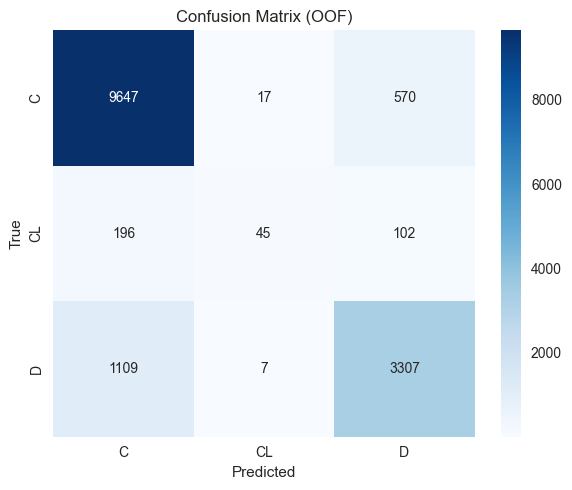

In [20]:
# --- PERFORMANCE METRICS & CONFUSION MATRIX ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("[Analysis] Computing performance metrics on OOF predictions...")

# Predicted class from OOF probabilities
y_pred_oof = np.argmax(oof_preds, axis=1)

# Metrics
acc = accuracy_score(y_encoded, y_pred_oof)
print(f"[Metrics] OOF Accuracy: {acc:.4f}")
print("[Metrics] Classification Report (OOF):")
print(classification_report(y_encoded, y_pred_oof, target_names=list(le.classes_)))

# Confusion Matrix
cm = confusion_matrix(y_encoded, y_pred_oof)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.title("Confusion Matrix (OOF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

[Analysis] Plotting ROC-AUC (OvR) and reliability diagram from OOF probabilities...
[Metrics] ROC-AUC (OvR) for class C: 0.9312
[Metrics] ROC-AUC (OvR) for class CL: 0.8914
[Metrics] ROC-AUC (OvR) for class D: 0.9353
[AutoSave] Saved figure: Reports/15_reliability_diagram_(oof)_20251127-211147.png


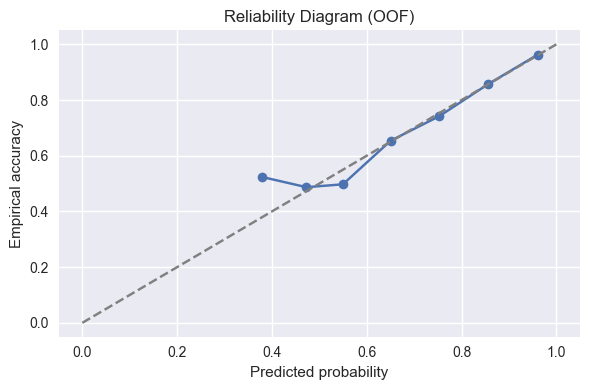

In [21]:
# --- PERFORMANCE VISUALS: ROC-AUC per class & Reliability Diagram ---
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

print(
    "[Analysis] Plotting ROC-AUC (OvR) and reliability diagram from OOF probabilities..."
)

# 1) ROC-AUC One-vs-Rest per class
try:
    n_classes = oof_preds.shape[1]
    for i, cls in enumerate(le.classes_):
        auc = roc_auc_score((y_encoded == i).astype(int), oof_preds[:, i])
        print(f"[Metrics] ROC-AUC (OvR) for class {cls}: {auc:.4f}")
except Exception as e:
    print(f"[Metrics] ROC-AUC calculation skipped: {e}")

# 2) Reliability diagram (probability calibration)
plt.figure(figsize=(6, 4))
# Use the max-class probability as confidence
conf = oof_preds.max(axis=1)
true = (np.argmax(oof_preds, axis=1) == y_encoded).astype(int)
prob_true, prob_pred = calibration_curve(true, conf, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Reliability Diagram (OOF)")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical accuracy")
plt.tight_layout()
plt.show()

In [23]:
# --- SUBMISSION ---
submission_df = pd.DataFrame(
    test_preds, columns=[f"Status_{cls}" for cls in le.classes_]
)
submission_df.insert(0, "id", test_ids)
submission_df = submission_df[["id", "Status_C", "Status_CL", "Status_D"]]

# Clip probabilities to prevent infinite logloss penalties
EPS = 1e-15
cols = ["Status_C", "Status_CL", "Status_D"]
submission_df[cols] = submission_df[cols].clip(EPS, 1 - EPS)
# Normalize rows to sum to 1
submission_df[cols] = submission_df[cols].div(submission_df[cols].sum(axis=1), axis=0)

submission_df.to_csv("submissions/submission.csv", index=False)
print("Submission file 'submission.csv' generated.")

Submission file 'submission.csv' generated.
